In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, TimeDistributed, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import mixed_precision
from tensorflow.keras.utils import Sequence

# Define your directories
#data_dir = os.path.join(os.path.expanduser("~"), "Desktop", "cse499b", "Extracted_landmarks_temp")
data_dir = "E:/Extracted_landmarks_temp"

# Define the image dimensions
img_width, img_height = 128, 128
num_channels = 3
batch_size = 16
epochs = 20
learning_rate = 0.0001

# Define the number of classes
classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
num_classes = len(classes)
print("Total number of classes:", num_classes)


Total number of classes: 200


In [3]:
# Define the number of subsets
num_subsets = 10

# Divide classes into subsets
classes_subsets = [classes[i:i + num_classes // num_subsets] for i in range(0, num_classes, num_classes // num_subsets)]
print(len(classes_subsets))

# Define the sequence length (number of frames per sequence)
sequence_length = 30

# Define arrays to store training and validation loss and accuracy
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Define arrays to store best validation accuracies for each subset
subset_best_val_accuracies = []

# Define a custom data generator to handle sequences of frames
class SequenceDataGenerator(Sequence):
    def __init__(self, data_dir, classes, sequence_length, img_width, img_height, batch_size, split_type):
        self.data_dir = data_dir
        self.classes = classes
        self.sequence_length = sequence_length
        self.img_width = img_width
        self.img_height = img_height
        self.batch_size = batch_size
        self.split_type = split_type

        # Prepare file paths and labels
        self.file_paths, self.labels = self._prepare_file_paths_and_labels()

        # Shuffle data
        self.on_epoch_end()

    def _prepare_file_paths_and_labels(self):
        file_paths = []
        labels = []
        for label_idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.data_dir, class_name)
            video_folders = [f for f in os.listdir(class_dir) if os.path.isdir(os.path.join(class_dir, f))]

            # Wrap the loop with tqdm to display progress
            for video_folder in tqdm(video_folders, desc=f"Processing {class_name}", unit="video"):
                video_dir = os.path.join(class_dir, video_folder)
                frame_files = sorted([os.path.join(video_dir, f) for f in os.listdir(video_dir)])
                if len(frame_files) >= self.sequence_length:
                    file_paths.append(frame_files[:self.sequence_length])
                    labels.append(label_idx)

        return file_paths, labels

    def __len__(self):
        # Return the number of batches per epoch
        return len(self.file_paths) // self.batch_size

    def __getitem__(self, index):
        # Prepare batch data and labels
        start_index = index * self.batch_size
        end_index = start_index + self.batch_size

        # Prepare arrays for data and labels
        batch_data = np.zeros((self.batch_size, self.sequence_length, self.img_width, self.img_height, 3))
        batch_labels = np.zeros((self.batch_size, len(self.classes)))

        # Use tqdm for tracking progress in data generation
        for i in range(start_index, end_index):
            # Load image data for the batch
            for j in range(self.sequence_length):
                img_path = self.file_paths[i][j]
                img = load_img(img_path, target_size=(self.img_width, self.img_height))
                img_array = img_to_array(img)
                img_array /= 255.0
                batch_data[i - start_index, j] = img_array

            # Set labels for the batch
            label_idx = self.labels[i]
            batch_labels[i - start_index, label_idx] = 1

        return batch_data, batch_labels

    def on_epoch_end(self):
        # Shuffle the data at the end of each epoch
        indices = np.arange(len(self.file_paths))
        np.random.shuffle(indices)
        self.file_paths = np.array(self.file_paths)[indices]
        self.labels = np.array(self.labels)[indices]

10


In [8]:
# Define a function to create the model
def create_model():
    model = Sequential()
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=(sequence_length, img_height, img_width, num_channels)))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(128, dropout=0.5))  # Add dropout to LSTM layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Add dropout to dense layer
    model.add(Dense(20, activation='softmax'))  # Output layer with number of classes units
    return model

# Initialize the model
model = create_model()

In [9]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

# Define your preferred directory
save_dir = 'Desktop/cse499b/frames_model'

# Make sure the directory exists
os.makedirs(save_dir, exist_ok=True)

# Train the model on subsets of classes
best_val_accuracies = []
for i, class_subset in enumerate(classes_subsets):
    print(f"\nTraining model for classes subset {i+1}/{len(classes_subsets)}")
    print("Classes in subset:", class_subset)

    # Initialize the training data generator for the subset
    train_generator = SequenceDataGenerator(data_dir, class_subset, sequence_length, img_width, img_height, batch_size, split_type='train')
    # Initialize the validation data generator for the subset
    val_generator = SequenceDataGenerator(data_dir, class_subset, sequence_length, img_width, img_height, batch_size, split_type='val')

    # Define callbacks
    checkpoint_path = os.path.join(save_dir, f'sign_language_model_subset_{i}.h5')
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=learning_rate), metrics=['accuracy'])
    history = model.fit(train_generator, epochs=epochs, steps_per_epoch=len(train_generator),
                        validation_data=val_generator, validation_steps=len(val_generator),
                        callbacks=[checkpoint, early_stopping])

    # Load the best model and evaluate on validation data
    best_model = load_model(checkpoint_path)
    val_loss, val_accuracy = best_model.evaluate(val_generator, steps=len(val_generator))
    best_val_accuracies.append(val_accuracy)

    # Store training and validation loss and accuracy
    train_losses.append(history.history['loss'])
    train_accuracies.append(history.history['accuracy'])
    val_losses.append(history.history['val_loss'])
    val_accuracies.append(history.history['val_accuracy'])

    # Save best validation accuracy for the subset
    subset_best_val_accuracies.append(val_accuracy)
    # Predict labels for validation data
y_pred = best_model.predict(val_generator, steps=len(val_generator))
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([val_generator[i][1] for i in range(len(val_generator))])
y_true_classes = np.argmax(y_true, axis=1)

# Calculate precision, recall and F1-score
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")


# Save train/validation data for plotting
train_val_data = {
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies
}
train_val_data_path = os.path.join(save_dir, 'train_val_data.npy')
np.save(train_val_data_path, train_val_data)

# Calculate overall best validation accuracy
overall_best_val_accuracy = np.mean(subset_best_val_accuracies)
print(f"Overall best validation accuracy: {overall_best_val_accuracy}")

# Save the final model
final_model_path = os.path.join(save_dir, 'sign_language_final_model_v1.h5')
model.save(final_model_path)



Training model for classes subset 1/10
Classes in subset: ['aam', 'aangti', 'aat', 'abhawa', 'ador', 'agun', 'akash', 'alo', 'amader', 'amar', 'ami', 'amra', 'apnader', 'apnara', 'apni', 'attio', 'baari', 'baba', 'bagan', 'bah']


Processing bah: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 19663.87video/s]


Epoch 1/20
37/37 [==============================] - ETA: 0s - loss: 3.0266 - accuracy: 0.0591
Epoch 1: val_accuracy improved from -inf to 0.05068, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_0.h5


D:\anaconda\envs\tf\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


37/37 [==============================] - 493s 13s/step - loss: 3.0266 - accuracy: 0.0591 - val_loss: 2.9950 - val_accuracy: 0.0507
Epoch 2/20
37/37 [==============================] - ETA: 0s - loss: 3.0037 - accuracy: 0.0405
Epoch 2: val_accuracy improved from 0.05068 to 0.08446, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_0.h5
37/37 [==============================] - 383s 10s/step - loss: 3.0037 - accuracy: 0.0405 - val_loss: 2.9913 - val_accuracy: 0.0845
Epoch 3/20
37/37 [==============================] - ETA: 0s - loss: 2.9995 - accuracy: 0.0524
Epoch 3: val_accuracy improved from 0.08446 to 0.10473, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_0.h5
37/37 [==============================] - 377s 10s/step - loss: 2.9995 - accuracy: 0.0524 - val_loss: 2.9907 - val_accuracy: 0.1047
Epoch 4/20
37/37 [==============================] - ETA: 0s - loss: 2.9942 - accuracy: 0.0490
Epoch 4: val_accuracy did not improve from 0.10473
37/37 [=

Processing chair: 100%|█████████████████████████████████████████████████████████████████████| 30/30 [00:00<?, ?video/s]


Epoch 1/20
37/37 [==============================] - ETA: 0s - loss: 3.0410 - accuracy: 0.0591
Epoch 1: val_accuracy improved from -inf to 0.09291, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_1.h5
37/37 [==============================] - 533s 14s/step - loss: 3.0410 - accuracy: 0.0591 - val_loss: 2.9668 - val_accuracy: 0.0929
Epoch 2/20
37/37 [==============================] - ETA: 0s - loss: 2.9799 - accuracy: 0.0693
Epoch 2: val_accuracy improved from 0.09291 to 0.13345, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_1.h5
37/37 [==============================] - 398s 11s/step - loss: 2.9799 - accuracy: 0.0693 - val_loss: 2.9336 - val_accuracy: 0.1334
Epoch 3/20
37/37 [==============================] - ETA: 0s - loss: 2.9388 - accuracy: 0.0760
Epoch 3: val_accuracy did not improve from 0.13345
37/37 [==============================] - 368s 10s/step - loss: 2.9388 - accuracy: 0.0760 - val_loss: 2.8554 - val_accuracy: 0.1199
Epoch 4/20


Processing doctor: 100%|██████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 4221.89video/s]


Epoch 1/20
37/37 [==============================] - ETA: 0s - loss: 3.1687 - accuracy: 0.0490
Epoch 1: val_accuracy improved from -inf to 0.07264, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_2.h5
37/37 [==============================] - 497s 13s/step - loss: 3.1687 - accuracy: 0.0490 - val_loss: 2.9842 - val_accuracy: 0.0726
Epoch 2/20
37/37 [==============================] - ETA: 0s - loss: 2.9981 - accuracy: 0.0625
Epoch 2: val_accuracy improved from 0.07264 to 0.11655, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_2.h5
37/37 [==============================] - 346s 9s/step - loss: 2.9981 - accuracy: 0.0625 - val_loss: 2.9488 - val_accuracy: 0.1166
Epoch 3/20
37/37 [==============================] - ETA: 0s - loss: 2.9703 - accuracy: 0.0811
Epoch 3: val_accuracy improved from 0.11655 to 0.15709, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_2.h5
37/37 [==============================] - 344s 9s/step - loss:

Processing golarhaar: 100%|██████████████████████████████████████████████████████| 30/30 [00:00<00:00, 13041.99video/s]


Epoch 1/20
37/37 [==============================] - ETA: 0s - loss: 3.2567 - accuracy: 0.0372
Epoch 1: val_accuracy improved from -inf to 0.08277, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_3.h5
37/37 [==============================] - 485s 13s/step - loss: 3.2567 - accuracy: 0.0372 - val_loss: 2.9667 - val_accuracy: 0.0828
Epoch 2/20
37/37 [==============================] - ETA: 0s - loss: 2.9798 - accuracy: 0.0743
Epoch 2: val_accuracy improved from 0.08277 to 0.12838, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_3.h5
37/37 [==============================] - 347s 9s/step - loss: 2.9798 - accuracy: 0.0743 - val_loss: 2.9015 - val_accuracy: 0.1284
Epoch 3/20
37/37 [==============================] - ETA: 0s - loss: 2.9110 - accuracy: 0.0895
Epoch 3: val_accuracy improved from 0.12838 to 0.19088, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_3.h5
37/37 [==============================] - 349s 9s/step - loss:

Processing khelowar: 100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 2051.47video/s]


Epoch 1/20
36/36 [==============================] - ETA: 0s - loss: 3.2889 - accuracy: 0.0556
Epoch 1: val_accuracy improved from -inf to 0.08507, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_4.h5
36/36 [==============================] - 484s 13s/step - loss: 3.2889 - accuracy: 0.0556 - val_loss: 2.9542 - val_accuracy: 0.0851
Epoch 2/20
36/36 [==============================] - ETA: 0s - loss: 2.9768 - accuracy: 0.0799
Epoch 2: val_accuracy improved from 0.08507 to 0.14931, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_4.h5
36/36 [==============================] - 333s 9s/step - loss: 2.9768 - accuracy: 0.0799 - val_loss: 2.8563 - val_accuracy: 0.1493
Epoch 3/20
36/36 [==============================] - ETA: 0s - loss: 2.8687 - accuracy: 0.1076
Epoch 3: val_accuracy improved from 0.14931 to 0.22049, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_4.h5
36/36 [==============================] - 328s 9s/step - loss:

Processing nana: 100%|███████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 10919.82video/s]


Epoch 1/20
37/37 [==============================] - ETA: 0s - loss: 3.4303 - accuracy: 0.0473
Epoch 1: val_accuracy improved from -inf to 0.05236, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_5.h5
37/37 [==============================] - 482s 12s/step - loss: 3.4303 - accuracy: 0.0473 - val_loss: 2.9966 - val_accuracy: 0.0524
Epoch 2/20
37/37 [==============================] - ETA: 0s - loss: 3.0067 - accuracy: 0.0524
Epoch 2: val_accuracy improved from 0.05236 to 0.07770, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_5.h5
37/37 [==============================] - 367s 10s/step - loss: 3.0067 - accuracy: 0.0524 - val_loss: 2.9594 - val_accuracy: 0.0777
Epoch 3/20
37/37 [==============================] - ETA: 0s - loss: 2.9527 - accuracy: 0.0676
Epoch 3: val_accuracy improved from 0.07770 to 0.17061, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_5.h5
37/37 [==============================] - 327s 9s/step - loss

Processing plate: 100%|███████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 2195.20video/s]


Epoch 1/20
37/37 [==============================] - ETA: 0s - loss: 3.6987 - accuracy: 0.0490
Epoch 1: val_accuracy improved from -inf to 0.09122, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_6.h5
37/37 [==============================] - 489s 13s/step - loss: 3.6987 - accuracy: 0.0490 - val_loss: 2.9623 - val_accuracy: 0.0912
Epoch 2/20
37/37 [==============================] - ETA: 0s - loss: 2.9828 - accuracy: 0.0591
Epoch 2: val_accuracy improved from 0.09122 to 0.11486, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_6.h5
37/37 [==============================] - 411s 11s/step - loss: 2.9828 - accuracy: 0.0591 - val_loss: 2.8931 - val_accuracy: 0.1149
Epoch 3/20
37/37 [==============================] - ETA: 0s - loss: 2.9171 - accuracy: 0.0980
Epoch 3: val_accuracy improved from 0.11486 to 0.21115, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_6.h5
37/37 [==============================] - 410s 11s/step - los

Processing sandal: 100%|██████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 2090.98video/s]


Epoch 1/20
37/37 [==============================] - ETA: 0s - loss: 3.3115 - accuracy: 0.0439
Epoch 1: val_accuracy improved from -inf to 0.07770, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_7.h5
37/37 [==============================] - 526s 13s/step - loss: 3.3115 - accuracy: 0.0439 - val_loss: 2.9651 - val_accuracy: 0.0777
Epoch 2/20
37/37 [==============================] - ETA: 0s - loss: 2.9775 - accuracy: 0.0608
Epoch 2: val_accuracy improved from 0.07770 to 0.12162, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_7.h5
37/37 [==============================] - 349s 9s/step - loss: 2.9775 - accuracy: 0.0608 - val_loss: 2.8531 - val_accuracy: 0.1216
Epoch 3/20
37/37 [==============================] - ETA: 0s - loss: 2.8999 - accuracy: 0.0811
Epoch 3: val_accuracy improved from 0.12162 to 0.20270, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_7.h5
37/37 [==============================] - 388s 11s/step - loss

Processing stree: 100%|███████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 7970.93video/s]


Epoch 1/20
37/37 [==============================] - ETA: 0s - loss: 3.4141 - accuracy: 0.0693
Epoch 1: val_accuracy improved from -inf to 0.06757, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_8.h5
37/37 [==============================] - 525s 14s/step - loss: 3.4141 - accuracy: 0.0693 - val_loss: 2.9667 - val_accuracy: 0.0676
Epoch 2/20
37/37 [==============================] - ETA: 0s - loss: 2.9949 - accuracy: 0.0625
Epoch 2: val_accuracy improved from 0.06757 to 0.09797, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_8.h5
37/37 [==============================] - 410s 11s/step - loss: 2.9949 - accuracy: 0.0625 - val_loss: 2.9086 - val_accuracy: 0.0980
Epoch 3/20
37/37 [==============================] - ETA: 0s - loss: 2.9322 - accuracy: 0.0811
Epoch 3: val_accuracy improved from 0.09797 to 0.16554, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_8.h5
37/37 [==============================] - 381s 10s/step - los

Processing virus: 100%|███████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 2402.60video/s]


Epoch 1/20
37/37 [==============================] - ETA: 0s - loss: 3.3757 - accuracy: 0.0676
Epoch 1: val_accuracy improved from -inf to 0.08615, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_9.h5
37/37 [==============================] - 523s 14s/step - loss: 3.3757 - accuracy: 0.0676 - val_loss: 2.9574 - val_accuracy: 0.0861
Epoch 2/20
37/37 [==============================] - ETA: 0s - loss: 2.9981 - accuracy: 0.0659
Epoch 2: val_accuracy improved from 0.08615 to 0.12669, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_9.h5
37/37 [==============================] - 404s 11s/step - loss: 2.9981 - accuracy: 0.0659 - val_loss: 2.9208 - val_accuracy: 0.1267
Epoch 3/20
37/37 [==============================] - ETA: 0s - loss: 2.9367 - accuracy: 0.0997
Epoch 3: val_accuracy did not improve from 0.12669
37/37 [==============================] - 383s 10s/step - loss: 2.9367 - accuracy: 0.0997 - val_loss: 2.8180 - val_accuracy: 0.1166
Epoch 4/20


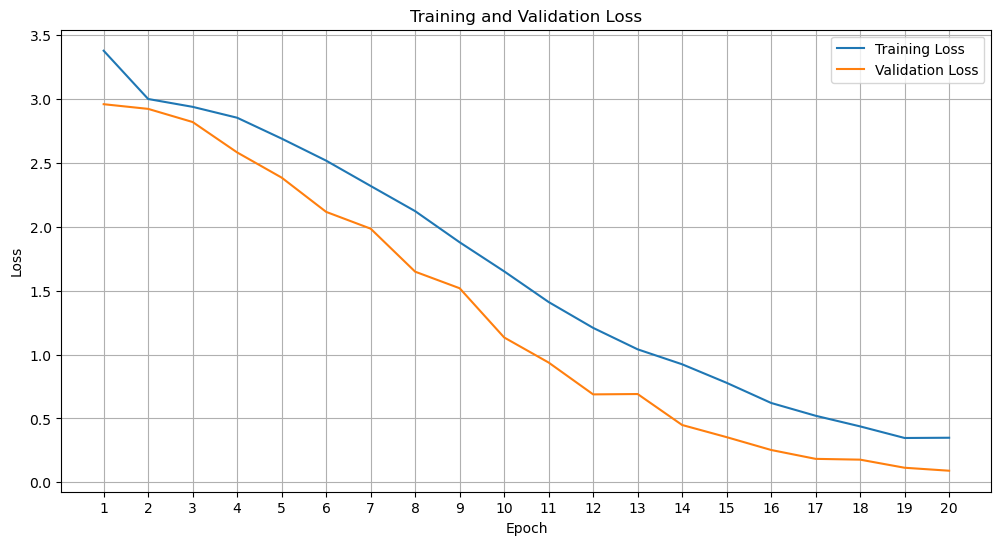

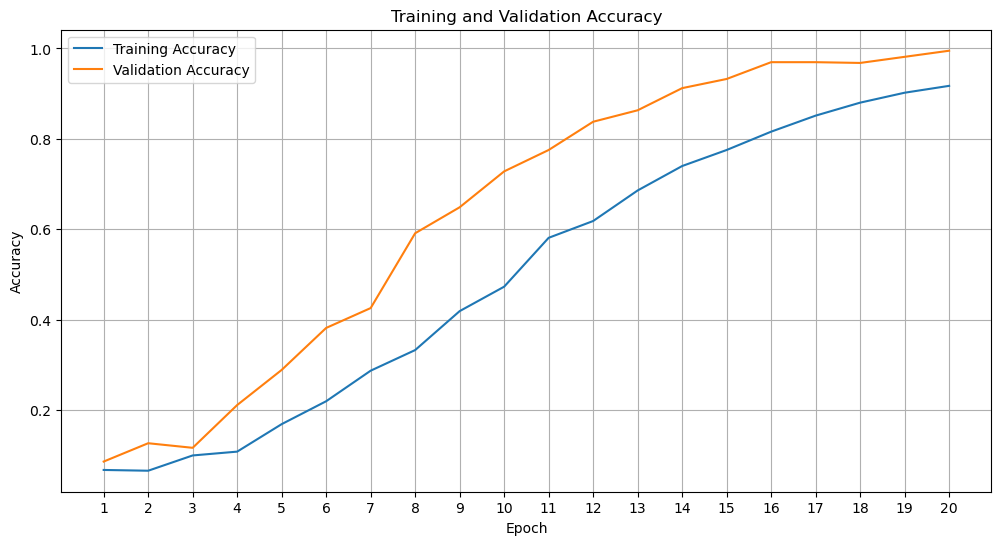

In [12]:
# import matplotlib.pyplot as plt

# Define the number of epochs
epochs = 20

# Define the epoch range for plotting
epoch_range = range(1, epochs + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(epoch_range, history.history['loss'], label='Training Loss')
plt.plot(epoch_range, history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epoch_range)  # Ensure integer values for epochs on x-axis
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(epoch_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epoch_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epoch_range)  # Ensure integer values for epochs on x-axis
plt.legend()
plt.grid(True)
plt.show()


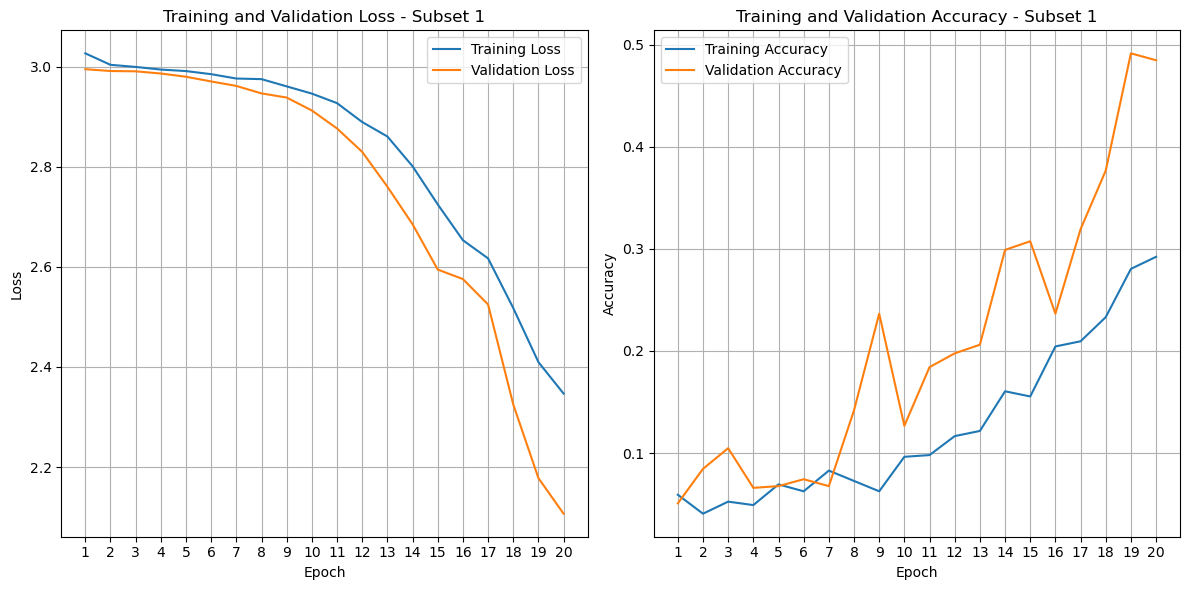

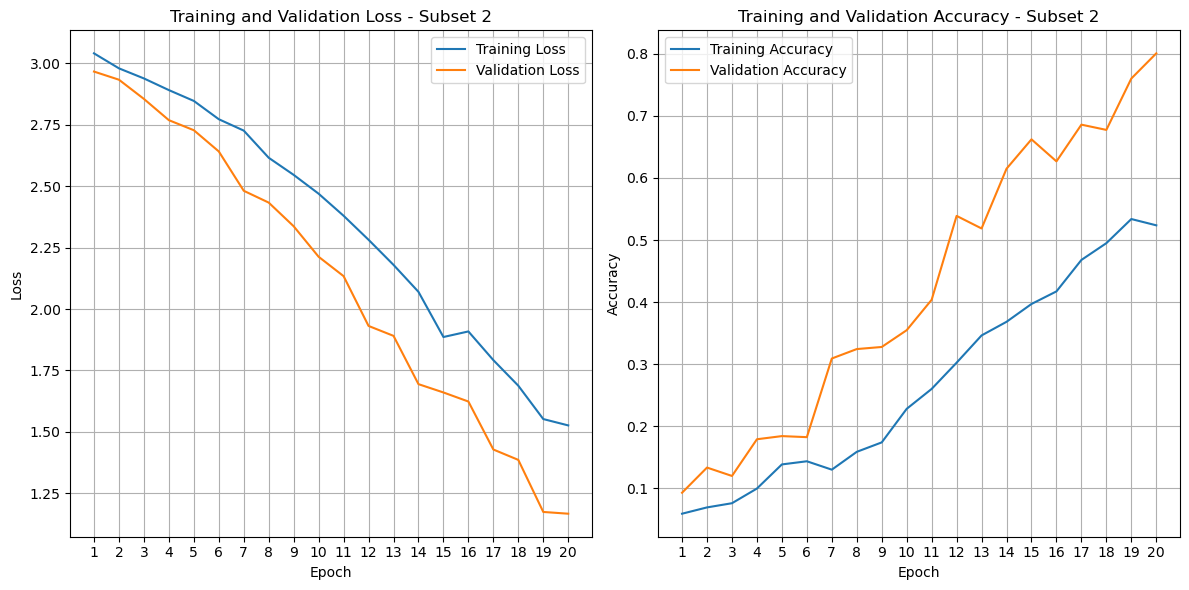

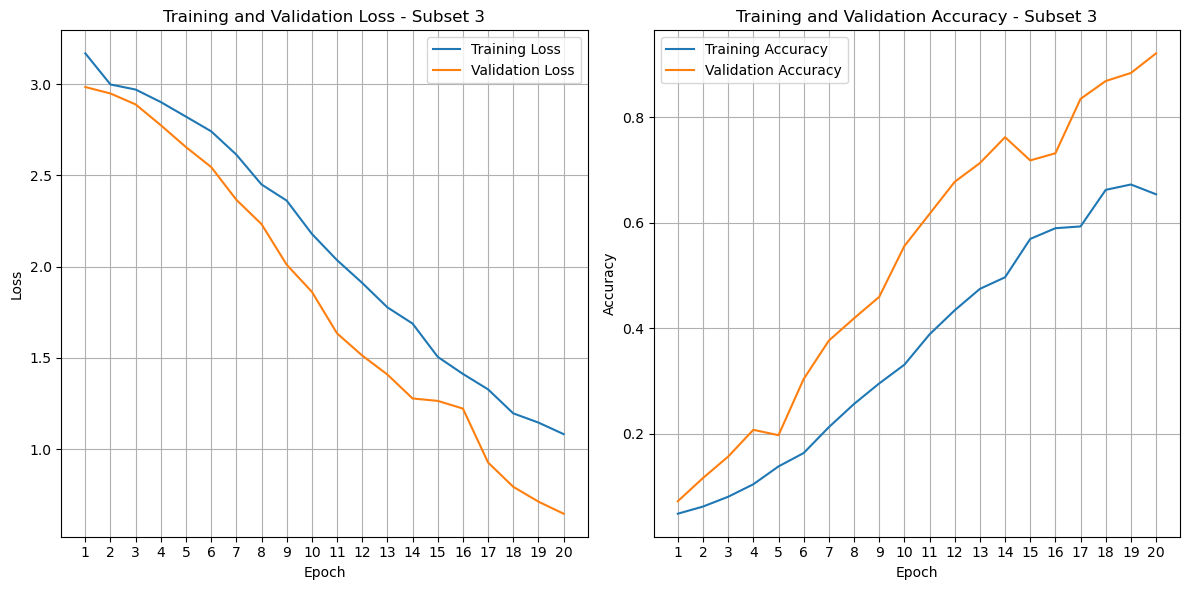

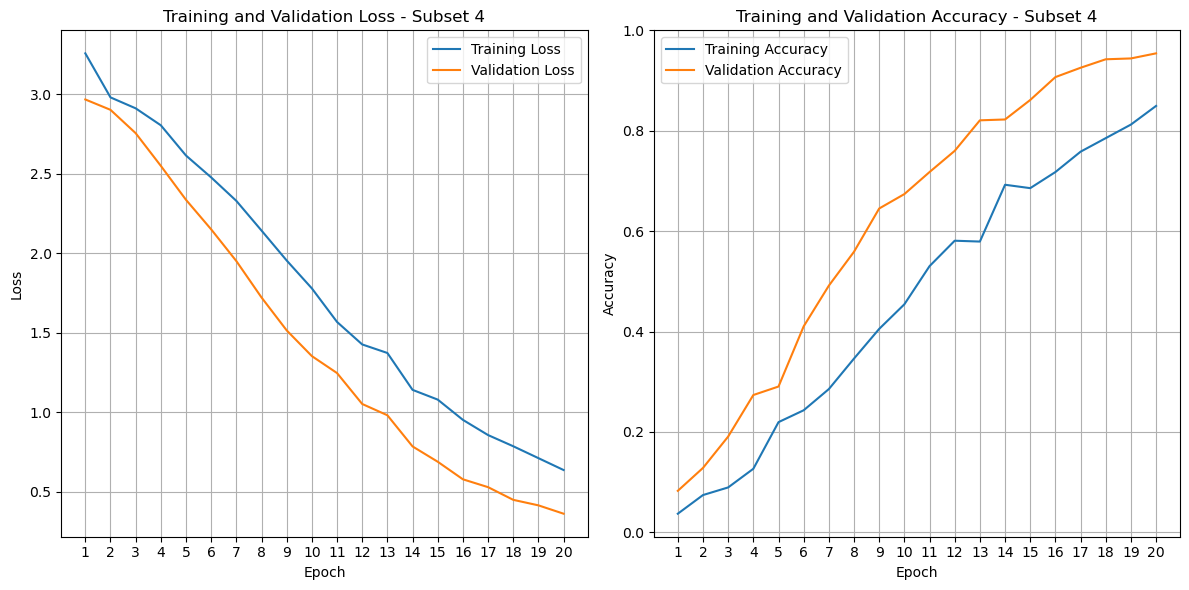

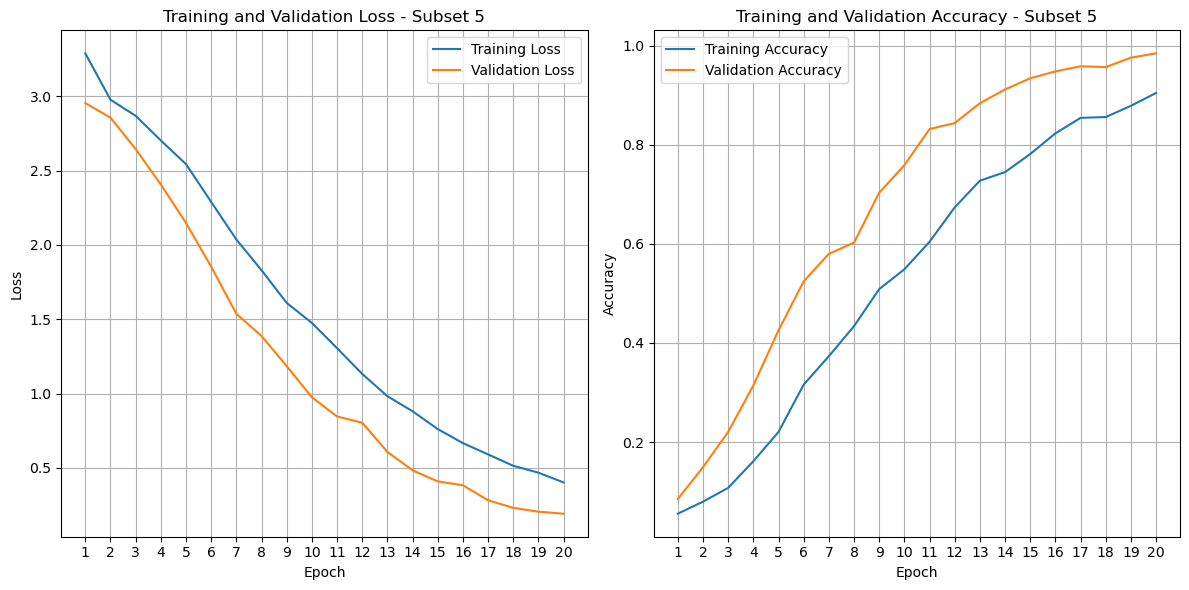

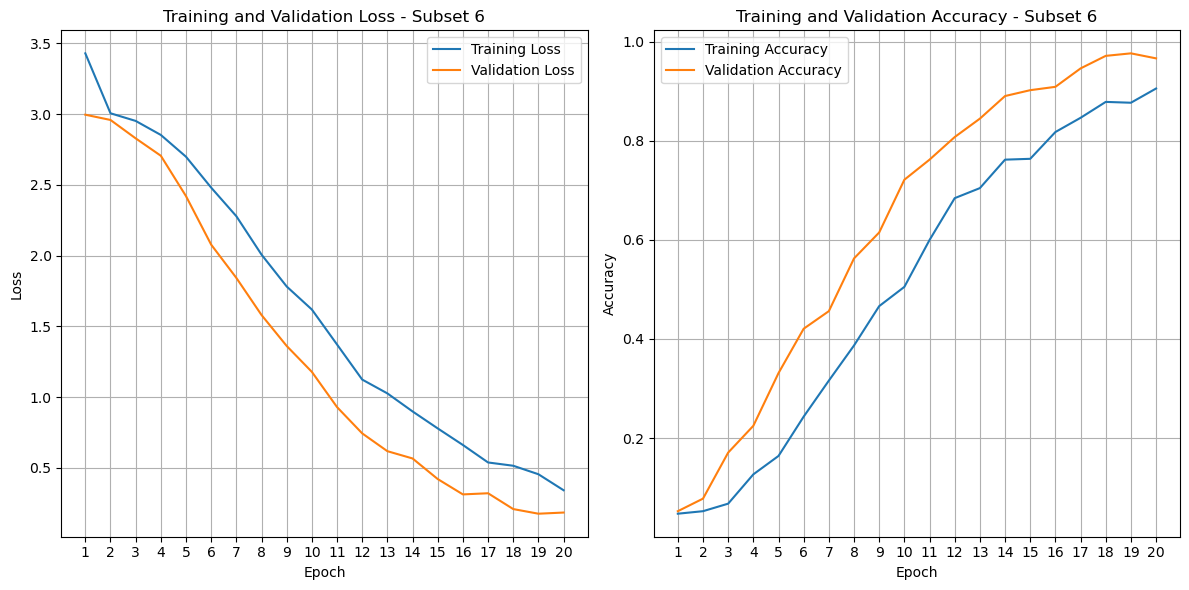

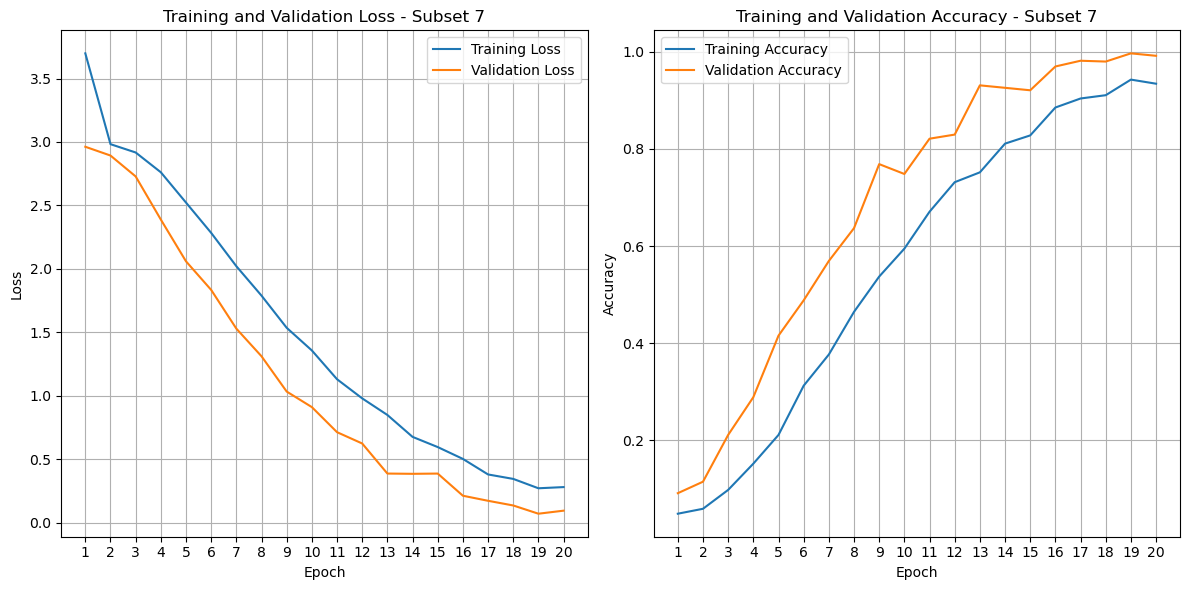

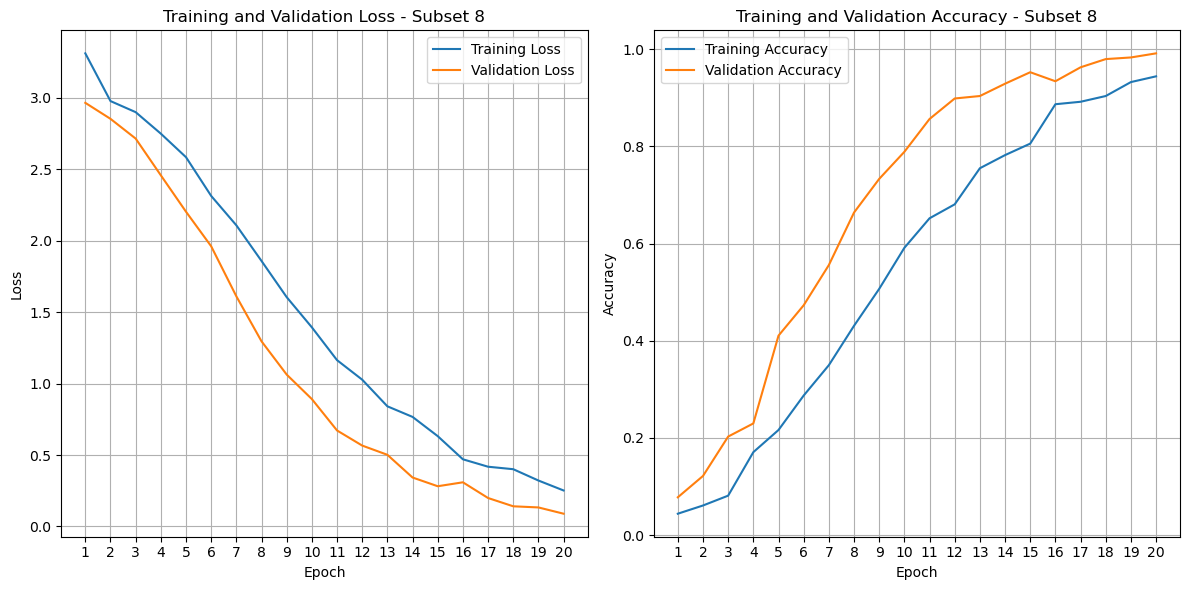

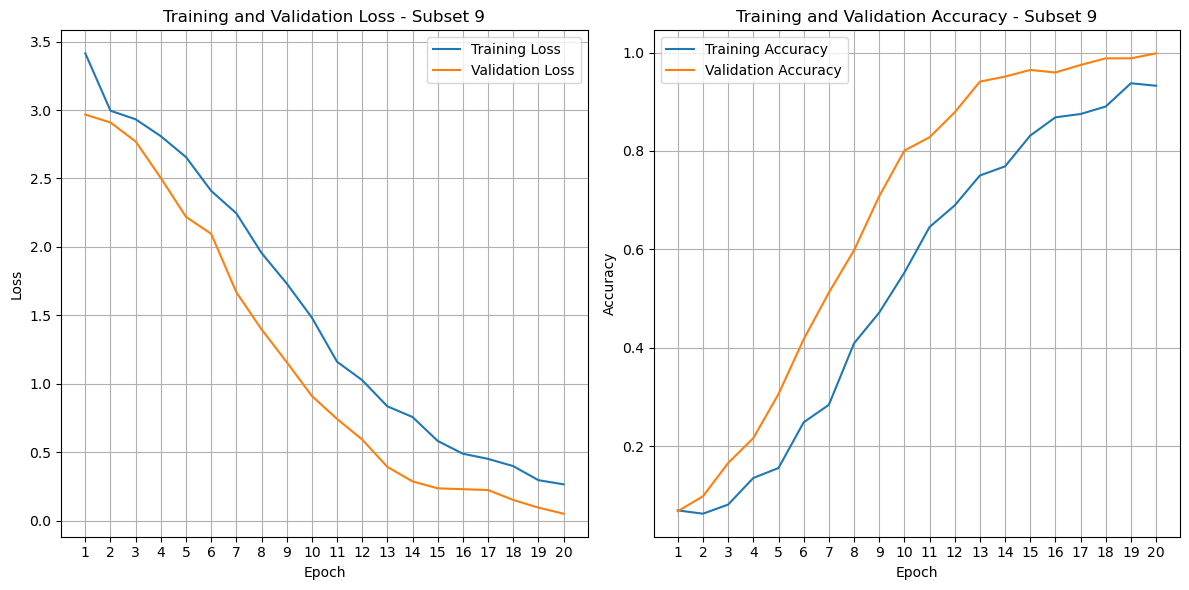

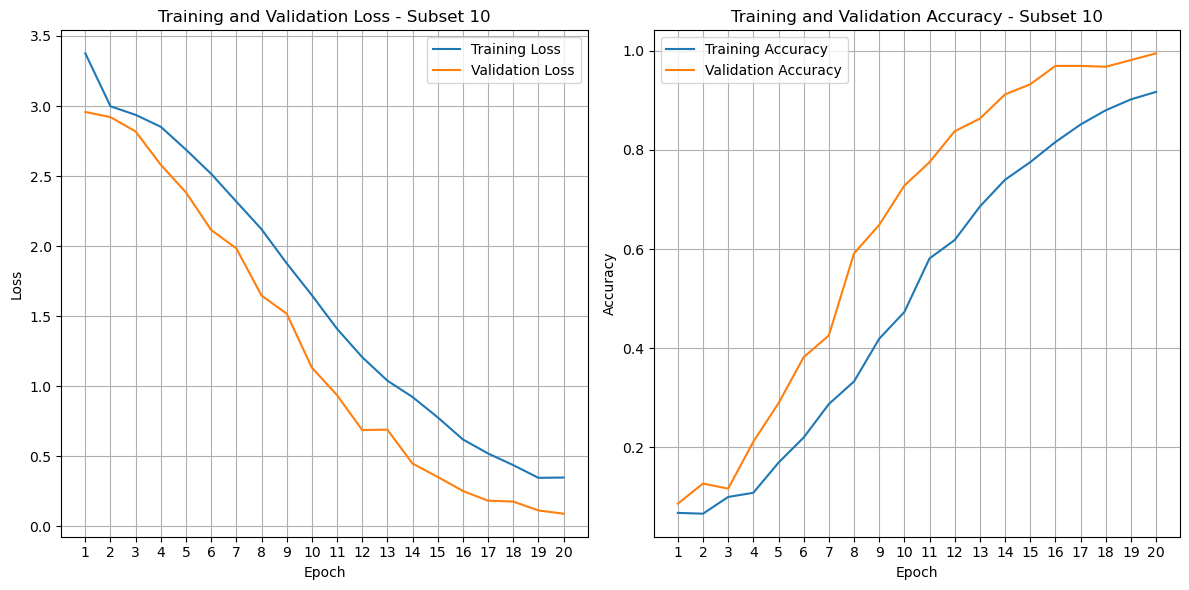

In [13]:
import matplotlib.pyplot as plt

# Define the number of epochs
epochs = 20

# Define the epoch range for plotting
epoch_range = range(1, epochs + 1)

# Plot loss and accuracy for each subset
for i in range(len(classes_subsets)):
    plt.figure(figsize=(12, 6))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epoch_range, train_val_data['train_losses'][i], label='Training Loss')
    plt.plot(epoch_range, train_val_data['val_losses'][i], label='Validation Loss')
    plt.title(f'Training and Validation Loss - Subset {i+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(epoch_range)  # Ensure integer values for epochs on x-axis
    plt.legend()
    plt.grid(True)

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epoch_range, train_val_data['train_accuracies'][i], label='Training Accuracy')
    plt.plot(epoch_range, train_val_data['val_accuracies'][i], label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy - Subset {i+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(epoch_range)  # Ensure integer values for epochs on x-axis
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
